In [1]:
import numpy as np
import matplotlib.pyplot as plt

#add different folder
import sys
sys.path.append('../Code')
import noise as ns

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [469]:
noiseou =  ns.OU_noise(sigma = 50, gamma = 1/1e2, x0 = 0)

In [15]:
import seaborn as sns



(0.0, 50.0)

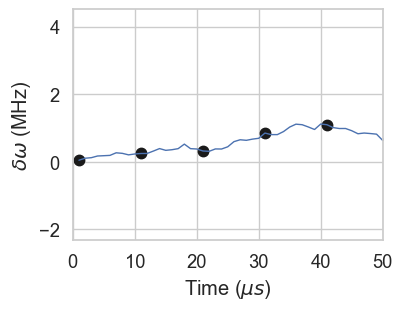

In [139]:

# Apply the default theme
sns.set(font_scale=1.2,style='whitegrid')
plt.figure(figsize=(4, 3))
x = np.linspace(1,L,int(L))

for k in range(10):
    plt.plot(x[::10][0+k*50:10+k*50],y[::10][k*50:10+k*50],"k.", ms = 15)
    plt.plot(x[::10][10+k*50:50+k*50],y[::10][10+k*50:50+k*50],"k.", ms = 15)

plt.plot(x,y,"-", lw=1)
plt.xlabel("Time ($\mu s$)")
plt.ylabel("$\delta \omega$ (MHz)")
plt.xlim(0,50)

Text(0, 0.5, '$\\delta \\omega$ (MHz)')

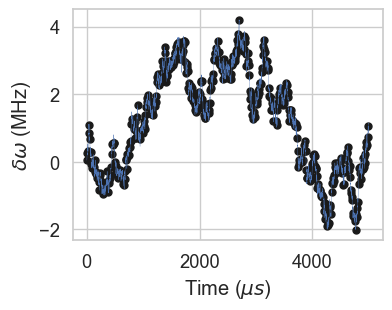

In [123]:

# Apply the default theme
sns.set(font_scale=1.2,style='whitegrid')
plt.figure(figsize=(4, 3))
x = np.linspace(1,L,int(L))

plt.plot(x[::10],y[::10],"k.", ms = 10)
plt.plot(x,y,"-",lw=0.25)
plt.xlabel("Time ($\mu s$)")
plt.ylabel("$\delta \omega$ (MHz)")


# Plot results vs penalty

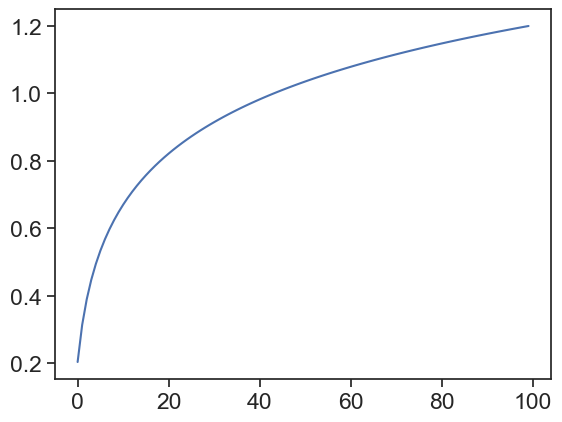

In [38]:
plt.plot(y)

2.1558788168186496
2.1558788168186496
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/var/folders/wj/x78z9z710q7csr068fhd10bxk7mx3x/T/ipykernel_74742/2034462835.py:26: RuntimeWarning: invalid value encountered in log
  return a*np.log(b*x)+c


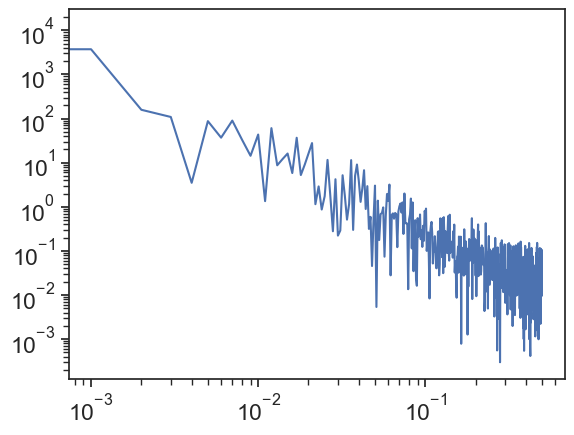

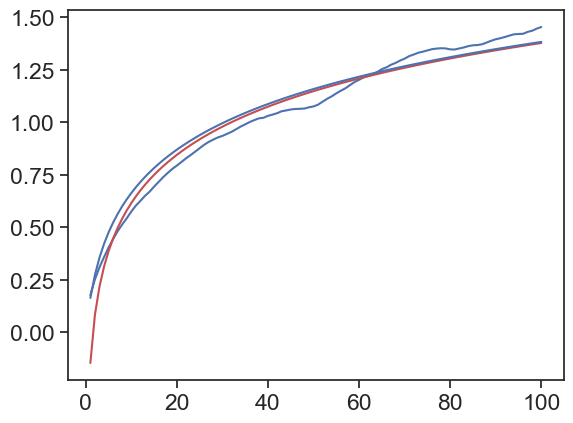

In [100]:
noise1f = nois.Over_f_noise(n_fluctuators = 10, S1 = 1e-2*0.4, sigma_couplings = 0.1, ommax = 1/100, ommin = 1/20000)
y = []
for k in range(1000):
    y.append(noise1f.update(1))
Sx,f =nois.get_spectrum(y,1,1000)
plt.figure()
plt.plot(Sx, f)
y = np.array(y)
plt.xscale("log")
plt.yscale("log")
plt.figure()
print(np.std(y))
stds = []
for k in range(100):
    k = k+1
    stds.append(np.mean(np.abs(y[k:] - y[:-k])))

print(np.std(y))


import numpy as np
from scipy.optimize import curve_fit
#fit the stds function to a log
# Define the form of the function you want to fit
def func(x, a, b,c):
    return a*np.log(b*x)+c

# Generate some data
x = np.arange(1, 101)
popt, pcov = curve_fit(func, x, stds)

a,b,c = popt
sig = lambda x: x + a*np.log(1+1/(np.exp((x-c)/a)/b))
y = [sig(0)]
for k in range(99):
    y.append(sig(y[-1]))

# Plot the data and the fitted model
plt.plot(x, stds, 'b', label='data')
plt.plot(x, func(x, *popt), 'r')
plt.plot(x,y)
cs = popt

In [44]:
import moments_backend as est
import noise as nois
import optimisation as opt
import gymnasium as gym
import os
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.callbacks import CheckpointCallback
from stable_baselines3.common.callbacks import EvalCallback
#import monitor
from stable_baselines3.common.monitor import Monitor
import importlib
importlib.reload(nois)
importlib.reload(opt)
importlib.reload(est)

<module 'moments_backend' from '/Users/krzywdaja/Documents/obsedian_test/Brain2/Science/Projects/Estimation-AI/presenation/../Code/moments_backend.py'>

In [91]:
om0=10
env = est.Moments_estimation_c(length = 1000, 
                                  om0 = om0, 
                                  noise = noise1f,
                                  max_time = 81,
                                  cs=cs,
                                  penalty = -1,
                                  time_step = 1,
                                  min_time = 1)
def policy_flip(n, **kwargs):
    return 0

def policy_random_p_c(n, state, *args, **kwargs):
    pflip = kwargs["x"][0]
    r = np.random.choice([0,1], p=[pflip,1-pflip])

    if r == 0:
        return 0
    else:
        return int(1/state[1]/state[0]*1e3/10)

def policy_interval_c(n,state, *args, **kwargs):
    x = kwargs["x"]
    Nflip = np.floor(x[0]) 
    Nest = np.floor(x[1])
    if (n % (Nflip+Nest)) < Nest:
        return int(1/state[1]/state[0]*1e3/10)
    elif (n % (Nflip+Nest)) < Nflip+Nest:
        return 0
    
policies = [policy_random_p_c, policy_interval_c]
xs = lambda p: [[1-p],[int(1/p),1]]
results = []
N = 50

probs = np.logspace(-4,np.log10(0.5),6)
infidelitiesf = np.zeros((len(policies),len(probs)))
for prob in probs:
    print(prob)
    for n,policy in enumerate(policies):
        results.append(data(opt.game(N, env, policy = policy, x = xs(prob)[n]),0))
        infidelitiesf[n,probs==prob] = results[-1].infidelity

0.0001
0.0005492802716530591
0.0030170881682725806
0.016572270086699918
0.09102821015130397
0.5


(0.0, 4000.0)

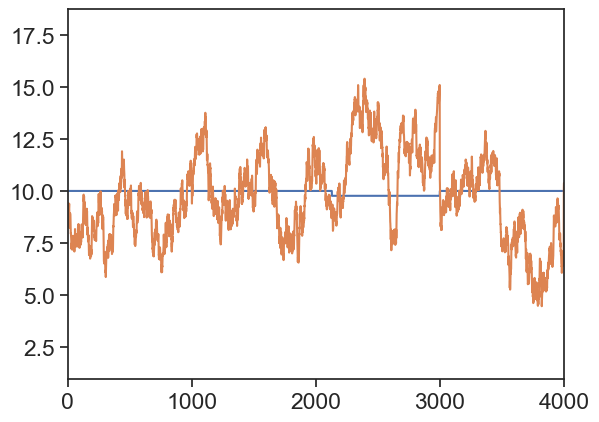

In [99]:
plt.plot(results[0].mus)
plt.plot(results[0].oms)
plt.xlim(0,4000)

In [27]:
infidelitiesf[0,:]

array([0., 0., 0., 0., 0., 0.])

In [93]:
def p_flip():
    s_om = 1/5
    x = 1
    f = lambda x: 1- (1/x)*(1-np.exp(-x))
    f(1)
    return 1/2-1/2*np.exp(-f(1)**2*(2*np.pi*np.pi)**2*s_om**2)    

In [94]:
p_flip()

0.439336257879791

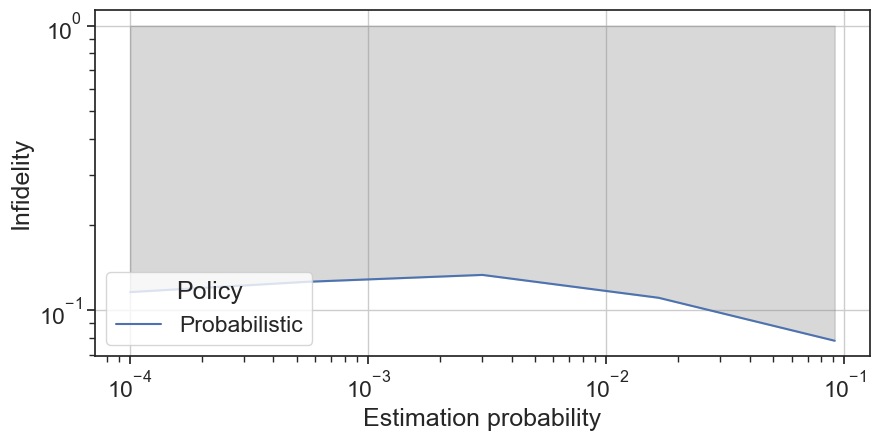

In [101]:
sns.set(font_scale=1.5,style="ticks")
plt.figure(figsize=(10, 4.5))
#plt.hlines(p_flip(),probs[0],probs[-2],color="k",linestyles="--",label="Always flip")  
ms = 10
plt.plot(probs[:-1],infidelitiesf[0,:-1],"-",ms=ms,label="Probabilistic")
#plt.plot(probs[:-1],infidelitiesf[1,:-1],"o-",ms=ms,label="Periodic")
plt.xscale("log")
plt.yscale("log")
plt.tick_params(axis='y', which='minor')
plt.xlabel("Estimation probability")
plt.ylabel("Infidelity")
plt.fill_between(probs[:-1],infidelitiesf[0,:-1],1,alpha=0.3, color="gray")
plt.grid(True)
#put log ticks
plt.legend(title="Policy", loc="lower left")
#plt.ylim(3*1e-4,1)


In [275]:
policies = []
for k in range(1):
    policies.append(data(results[k], 0))
    print(policies[k].est_prob)
    print(policies[k].fidelity)


0.04894
0.9712636426723866


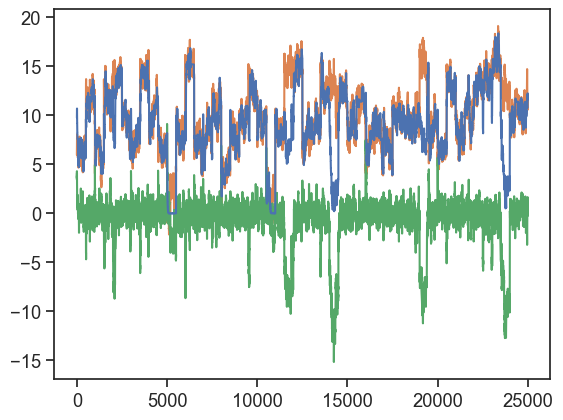

In [401]:
plt.plot(results[-1].mus,zorder=5)
plt.plot(results[-1].oms)
plt.plot(results[-1].errors)

In [172]:
data.return_row()

array([-0.01      ,  0.48831786,  0.05288   ,  0.93462   ,  0.98680209])

In [8]:


class data():
    def __init__(self, res, penalty):
        self.penalty = penalty
        self.actions = res.actions.flatten()
        self.rewards = res.rewards.flatten()
        self.mus = res.mus.flatten()
        self.oms = res.oms.flatten()
        self.stds = res.stds.flatten()*self.mus
        self.errors = self.mus-self.oms
        self.est_prob = np.sum(self.rewards==0)/len(self.rewards)
        self.succ_prob = np.sum(self.rewards==1)/len(self.rewards)
        self.fidelity = np.sum(self.rewards==1)/(np.sum(self.rewards<0)+np.sum(self.rewards==1))
        self.infidelity = np.sum(self.rewards<0)/(np.sum(self.rewards<0)+np.sum(self.rewards==1))

    def return_row(self):
        row = []
        row.append(self.penalty)
        row.append(np.mean(np.abs(self.errors)))
        row.append(self.est_prob)
        row.append(self.succ_prob)
        row.append(self.fidelity)
        return np.array(row)


In [461]:
om0 = 10
#penalty = [-0.1,-1,-5,-25]  #with ts = 1, max_time = 50
penalty = [-0.01,-50]  # with ts = 5, max_time = 81
results_t = []
N = 50
for p in penalty:
    env = est.Moments_estimation(length = 1000, 
                                  om0 = om0, 
                                  noise = noiseou,
                                  cs = 2,
                                  max_time = 500,
                                  penalty = p,
                                  time_step = 1,
                                  min_time = 1)
    #model = PPO("MlpPolicy", env, verbose=1, tensorboard_log="./ppo_bayes_tensorboard/", gamma = 1)
    model = model.load("../Code/logs2/t"+str(p)+"/best_model.zip")
   
    results_t.append(opt.game(N, env, model))

'''
penalty = [-0.01,-1,-10,-20,-50]
for p in penalty:
    env = est.Moments_estimation_c(length = 20000, 
                                om0 = om0, 
                                noise = noiseou,
                                cs = 2,
                                max_time = 500,
                                penalty = p,
                                time_step = 1,
                                min_time = 1)
    model = model.load("../Code/logs2/c"+str(p)+"/best_model.zip")
   
    results.append(opt.game(N, env, model))

'''


'\npenalty = [-0.01,-1,-10,-20,-50]\nfor p in penalty:\n    env = est.Moments_estimation_c(length = 20000, \n                                om0 = om0, \n                                noise = noiseou,\n                                cs = 2,\n                                max_time = 500,\n                                penalty = p,\n                                time_step = 1,\n                                min_time = 1)\n    model = model.load("../Code/logs2/c"+str(p)+"/best_model.zip")\n   \n    results.append(opt.game(N, env, model))\n\n'

In [466]:
datas_t = []
for result in results_t:
    datas_t.append(data(result,0))